# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
_Carlos Alberto Gómez Prado_ | __IBM Data Science Professional Certificate__  

### Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [Resources](#resources)

<a name="introduction"></a>
### Introduction

**Background:** When we try to start something new, our mind fills with ideas to get into the most profitable business possible, the one that provides us with financial stability and extra money for our guilty whims and tastes. However, finding the perfect business is a utopian and somewhat emotional idea, considering that the world economy is in a very delicate state, limiting the purchasing power of certain sectors and hindering the path of the entrepreneur who does not have the right tools and strategies to grow his business or start a business. However, in Argentina, as in the case of Cordoba Capital, there are several categories that prevail over time despite the economic crisis that the country has gone through; gastronomy is a clear example of the competitive market since everyone has the need to feed themselves. Some of the most important issues to consider before investing in some of the categories would be to research and explore.

**A bit of history:** Cordoba is located in the central region, on the banks of the Suquia River.    
It is the second most populated city in Argentina after Buenos Aires and the largest in the country and is an important cultural, economic, educational, financial and entertainment center in the region.It was founded by the Sevillian Jerónimo Luis de Cabrera on July 6, 1573, as a Spanish city that would serve as a refuge against the natives,so you can move around and trade freely.It is an important cultural factory, which receives university students from all over the country and the world. Its University, founded in 1613, is the first in Argentina and the fourth oldest in America and is considered one of the most important in the continent.   
 
**Business problem:** The objective of the project is to explore the most popular categories in the city of Córdoba, Argentina, and thus provide the investor with a free tool to analyze the general panorama of the most popular categories in this waterway of the people. This will help to improve many aspects in the decision making process and will provide great knowledge to be able to plan the success of the business using it as information or simply to be able to put our business idea into action. To do this we will focus on 5 strategic points of the city, which we will break down supported by the Foursquare tool.   

**Objective:** With the geographic and demographic information extracted from the research,we will have a generalised picture of the preferences and opportunities in different parts of the city. In this way we can ask ourselves: What is the best option to consider? What types of categories dominate the market? Which places are the most preferred? What type of place prevails over time? You will have this knowledge and be able to evaluate the best way forward.

<a name="data"></a>
## Data

**About the data:** 
The data to be used are of free access, we will rely on the wikipedia from which the information will be scraped to obtain a data frame with the information of the neighborhoods of Cordoba Capital. With all this information we will proceed to extract the relevant information for the investigation and thus be able to represent it graphically with its real geographical location and be able to analyze the different sectors in a radius of up to 500 meters from the point of origin of each area. The strategic points to be investigated are located in strategic areas that are widely used by the population and by my own knowledge living in this city. In the resources section you will find detailed links to the sites used.

* The coordinates of Cordoba Capital will be obtained using the geocoding of the GeoPy library, as well as the areas of research will be obtained using the reverse geocoding of the GeoPy library.
* The information about the business categories in a range of 500 meters, their type and location in each neighborhood will be obtained using the Quadrangular API.



### Import 
In this section you download and install the packages and functions needed for the project.

In [71]:
!pip install beautifulsoup4 # HTML and XML data extraction library.
!pip install request # requests , timeout
!pip install folium
# Importing Packages
import pandas as pd # DataFrame
import numpy as np # Arrays
import folium
from bs4 import BeautifulSoup # HTML and XML data extraction library.
import requests # requests , timeout
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
tqdm.pandas()
import matplotlib.cm as cm 
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('ggplot') # optional: for ggplot-like style

# Functions

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function that extracts informations    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']

    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

print("Ready")

Ready


### Scraping & Exploration
With the information taken from wikipedia a data frame will be created filtering the necessary information from the areas of interest.

In [72]:
# Loading the url data.
url = 'https://nuestraciudad.info/portal/Portal:Tabla_de_barrios_de_C%C3%B3rdoba'
page_response = requests.get(url,timeout=5) # requests , timeout
soup = BeautifulSoup(page_response.content,'lxml') # Transforming to BeautifulSoup object
table = soup.find_all('table')[0] # Filtering the html data table
df = pd.read_html(str(table))[0] # Transforming data with pandas
df.columns = ['Neighborhood', 'Surface', 'Population 2001', 'Density', 'Increase x decade', 'Borough']
df = df.astype(str).apply(lambda x: x.str.upper()) # convert DataFrame to capital letters
print("size: ",df.shape) # size
df.head() # Transposed DataFrame

size:  (415, 6)


,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
0,BARRIO 1 DE MAYO,NAN,10.045,NAN,-932.0,ZONA INTERMEDIA SUDESTE
1,BARRIO 16 DE NOVIEMBRE,"0,407 KM²40,7 HA 4.070 A 407.000 M²",2.084,"5.120,39 HAB/KM²51,204 HAB/HA",NAN,NAN
2,BARRIO 2 DE SEPTIEMBRE,"0,585 KM²58,49 HA 5.849 A 584.900 M²",8.252,NAN,36833.0,ZONA ARGÜELLO
3,BARRIO 20 DE JUNIO,"0,0394 KM²3,94 HA 394 A 39.400 M²",680.0,NAN,-3145.0,ZONA PERICENTRAL NORTE
4,BARRIO 23 DE ABRIL,"0,176 KM²17,61 HA 1.761 A 176.100 M²",1.517,"8.614,42 HAB/KM²86,144 HAB/HA",-9965.0,ZONA PERIFÉRICA SUDESTE


We can verify that we have 415 registered neighborhoods with relevant information such as population and increase or decrease by decades,    
which will give us a general vision of the distribution of the inhabitants by sectors according to time.
***

### Grouping by Borough 
They will be grouped by zones to evaluate the amount of available neighborhoods in the table.   

In [73]:
df.groupby('Borough').count().transpose()

Borough,NAN,ZONA ARGÜELLO,ZONA CENTRAL,ZONA CERRO,ZONA GUIÑAZÚ,ZONA INTERMEDIA ESTE,ZONA INTERMEDIA NORDESTE,ZONA INTERMEDIA NOROESTE,ZONA INTERMEDIA NORTE,ZONA INTERMEDIA OESTE,...,ZONA PERICENTRAL SUDESTE,ZONA PERICENTRAL SUDOESTE,ZONA PERICENTRAL SUR,ZONA PERIFÉRICA ESTE,ZONA PERIFÉRICA NORDESTE,ZONA PERIFÉRICA NORTE,ZONA PERIFÉRICA OESTE,ZONA PERIFÉRICA SUDESTE,ZONA PERIFÉRICA SUDOESTE,ZONA PERIFÉRICA SUR
Neighborhood,7,38,16,18,7,6,19,6,12,15,...,14,22,2,4,6,4,7,25,2,26
Surface,7,38,16,18,7,6,19,6,12,15,...,14,22,2,4,6,4,7,25,2,26
Population 2001,7,38,16,18,7,6,19,6,12,15,...,14,22,2,4,6,4,7,25,2,26
Density,7,38,16,18,7,6,19,6,12,15,...,14,22,2,4,6,4,7,25,2,26
Increase x decade,7,38,16,18,7,6,19,6,12,15,...,14,22,2,4,6,4,7,25,2,26


The area filter focuses on 5 key locations with a lot of social movement distributed in 2 important zones.
* ZONA CENTRAL 
   * Plaza San Martin
   * Paseo del Buen Pastor
   * Museo iberoamericano de artesanias de Fundart
   * Paseo Sobremonte    
    
    
* ZONA PERICENTRAL ESTE
   * Plaza Alberdi   

### Filtering the first group : ZONA CENTRAL 
From the central group there are 4 places, 2 of which are in the same neighborhood.

In [74]:
# Filter borough
filter_01 = df['Borough'] == 'ZONA CENTRAL'
g_01 = df[filter_01]
# Filter group 1
b_01 = g_01[3:4] # loc BARRIO CENTRO
b_02 = g_01[3:4] # loc BARRIO CENTRO
b_03 = g_01[7:8] # loc BARRIO GÜEMES
b_04 = g_01[9:10] # Loc BARRIO NUEVA CÓRDOBA 
print("Size: ",g_01.shape)
g_01

Size:  (16, 6)


,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
10,BARRIO ALBERDI,"2,454 KM²245,36 HA 24.536 A 2.453.600 M²",31.594,NAN,-25.0,ZONA CENTRAL
61,BARRIO BAJADA SAN ROQUE,"0,0528 KM²5,28 HA 528 A 52.800 M²",296.0,"5.606,06 HAB/KM²56,061 HAB/HA",-4488.0,ZONA CENTRAL
66,BARRIO BELLA VISTA,"0,53 KM²53 HA 5.300 A 530.000 M²",4.437,"8.371,7 HAB/KM²83,717 HAB/HA",-1103.0,ZONA CENTRAL
80,BARRIO CENTRO,"2,887 KM²288,73 HA 28.873 A 2.887.300 M²",28.949,NAN,-1699.0,ZONA CENTRAL
110,BARRIO CUPANI,"0,213 KM²21,33 HA 2.133 A 213.300 M²",2.133,NAN,-129.0,ZONA CENTRAL
111,BARRIO CÁCERES,"0,133 KM²13,33 HA 1.333 A 133.300 M²",1.143,"8.574,64 HAB/KM²85,746 HAB/HA",-2139.0,ZONA CENTRAL
115,BARRIO DUCASSE,"0,161 KM²16,12 HA 1.612 A 161.200 M²",935.0,"5.800,25 HAB/KM²58,003 HAB/HA",NAN,ZONA CENTRAL
147,BARRIO GÜEMES,NAN,11.679,NAN,-1491.0,ZONA CENTRAL
231,BARRIO MAURIZI,"0,119 KM²11,9 HA 1.190 A 119.000 M²",683.0,"5.739,5 HAB/KM²57,395 HAB/HA",-1537.0,ZONA CENTRAL
240,BARRIO NUEVA CÓRDOBA,"1,234 KM²123,37 HA 12.337 A 1.233.700 M²",29.412,NAN,2498.0,ZONA CENTRAL


In [75]:
g_01[3:4]

,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
80,BARRIO CENTRO,"2,887 KM²288,73 HA 28.873 A 2.887.300 M²",28.949,NAN,-1699.0,ZONA CENTRAL


In [76]:
g_01[7:8]

,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
147,BARRIO GÜEMES,NAN,11.679,NAN,-1491.0,ZONA CENTRAL


In [77]:
g_01[9:10]

,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
240,BARRIO NUEVA CÓRDOBA,"1,234 KM²123,37 HA 12.337 A 1.233.700 M²",29.412,NAN,2498.0,ZONA CENTRAL


In this group our target are 3 : "BARRIO CENTRO" , "BARRIO GÜEMES" and "BARRIO NUEVA CÓRDOBA".

### Filtering the second group : ZONA PERICENTRAL ESTE 
From the eastern pericentral group : there is only 1 place, which interests us "BARRIO GENERAL PAZ".

In [78]:
# Filter borough
filter_02 = df['Borough'] == 'ZONA PERICENTRAL ESTE'
g_02 = df[filter_02]
# Filter group 2
b_05 = g_02[1:2] # loc BARRIO GENERAL PAZ
print("size: ",g_02.shape)
g_02

size:  (7, 6)


,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
64,BARRIO BAJO GENERAL PAZ,"0,125 KM²12,54 HA 1.254 A 125.400 M²",1.203,"9.593,3 HAB/KM²95,933 HAB/HA",-1474.0,ZONA PERICENTRAL ESTE
138,BARRIO GENERAL PAZ,"1,151 KM²115,13 HA 11.513 A 1.151.300 M²",8.085,"7.022,5 HAB/KM²70,225 HAB/HA",-1038.0,ZONA PERICENTRAL ESTE
139,BARRIO GENERAL PUEYRREDÓN,"2,988 KM²298,77 HA 29.877 A 2.987.700 M²",21.598000000000003,"7.228,97 HAB/KM²72,29 HAB/HA",-132.0,ZONA PERICENTRAL ESTE
149,BARRIO HOGAR PROPIO,"0,495 KM²49,48 HA 4.948 A 494.800 M²",6.199,NAN,3297.0,ZONA PERICENTRAL ESTE
175,BARRIO JUNIORS,"0,836 KM²83,63 HA 8.363 A 836.300 M²",7.053,"8.433,58 HAB/KM²84,336 HAB/HA",-292.0,ZONA PERICENTRAL ESTE
277,BARRIO PATRIA,"0,249 KM²24,87 HA 2.487 A 248.700 M²",2.036,"8.186,57 HAB/KM²81,866 HAB/HA",-1362.0,ZONA PERICENTRAL ESTE
410,BARRIO YAPEYÚ,"0,755 KM²75,46 HA 7.546 A 754.600 M²",8.338,NAN,-674.0,ZONA PERICENTRAL ESTE


In [79]:
g_02[1:2]

,Neighborhood,Surface,Population 2001,Density,Increase x decade,Borough
138,BARRIO GENERAL PAZ,"1,151 KM²115,13 HA 11.513 A 1.151.300 M²",8.085,"7.022,5 HAB/KM²70,225 HAB/HA",-1038.0,ZONA PERICENTRAL ESTE


In this group our objective is "BARRIO GENERAL PAZ".

### The 5 outstanding neighborhoods are:
* Paseo del Buen Pastor
* Plaza San Martin
* Museo iberoamericano de artesanias de Fundart
* Plaza Alberdi
* Paseo Sobremonte   

With the filtered neighborhood groups we sort it into a new data frame by adding the postal code.  

In [80]:
#loc 1 : Plaza San Martin
b_01['Location'] = b_01['Location'] = 'Plaza San Martin, X5000'
#loc 2 : Paseo Sobremonte
b_02['Location'] = b_02['Location'] = 'Paseo Sobremonte, X5000'
#loc 3 : Museo
b_03['Location'] = b_03['Location'] = 'Museo iberoamericano de artesanias de Fundart, X5000'
#loc 4 : Paseo del Buen Pastor
b_04['Location'] = b_04['Location'] = 'Paseo del Buen Pastor, X5000'
#Loc 5 Plaza Alberdi
b_05['Location'] = b_05['Location'] = 'Plaza Alberdi, X5004'
#Join data
frames = [b_01, b_02, b_03,b_04,b_05]
nb_select = pd.concat(frames)
nb_select.index = np.arange(0, len(nb_select)) # changing index
nb_select.drop(['Surface','Density'], axis = 1, inplace = True) 
nb_select['Population 2001'] = nb_select['Population 2001'].astype(float)
nb_select['Increase x decade'] = nb_select['Increase x decade'].astype(float)
info_stack = pd.concat([nb_select['Population 2001'], nb_select['Increase x decade']], axis=1)
print("Size: ",nb_select.shape)
nb_select.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Size:  (5, 5)


,Neighborhood,Population 2001,Increase x decade,Borough,Location
0,BARRIO CENTRO,28.949,-1699.0,ZONA CENTRAL,"Plaza San Martin, X5000"
1,BARRIO CENTRO,28.949,-1699.0,ZONA CENTRAL,"Paseo Sobremonte, X5000"
2,BARRIO GÜEMES,11.679,-1491.0,ZONA CENTRAL,"Museo iberoamericano de artesanias de Fundart,..."
3,BARRIO NUEVA CÓRDOBA,29.412,2498.0,ZONA CENTRAL,"Paseo del Buen Pastor, X5000"
4,BARRIO GENERAL PAZ,8.085,-1038.0,ZONA PERICENTRAL ESTE,"Plaza Alberdi, X5004"


Note: Since the key places are public areas and are within a similar range there are only 2 zip codes.   
* ZONA CENTRAL - Postal Code X5000
* ZONA PERICENTRAL ESTE - Postal Code X5004

In [81]:
print('There are {} uniques categories.'.format(len(nb_select['Borough'].unique())))
print(nb_select['Borough'][0],",",nb_select['Borough'][4])
nb_select.groupby('Neighborhood').count()

There are 2 uniques categories.
ZONA CENTRAL , ZONA PERICENTRAL ESTE


,Population 2001,Increase x decade,Borough,Location
Neighborhood,,,,
BARRIO CENTRO,2,2,2,2
BARRIO GENERAL PAZ,1,1,1,1
BARRIO GÜEMES,1,1,1,1
BARRIO NUEVA CÓRDOBA,1,1,1,1


We can see how the categories are distributed in the different neighborhoods.

### Figure 1 
You can see how the most important areas according to the distribution of their population by area.

In [82]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

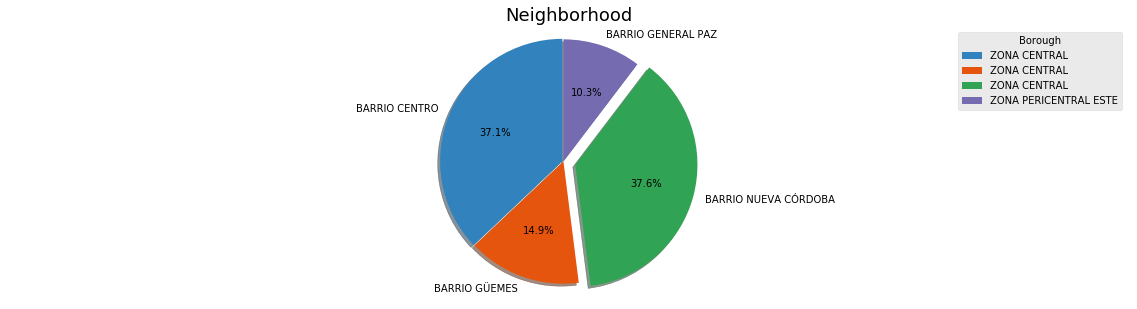

In [83]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(4)*4)
labels =  nb_select['Neighborhood'][1:5].values
sizes = nb_select['Population 2001'][1:5]
explode = (0.01, 0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(20, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=outer_colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Neighborhood",size=18)
ax1.legend(title="Borough",labels=nb_select['Borough'][1:5].values)
plt.show()

### Figure 2 
The population can be distinguished over the decades, with a maximum of 24,412 people in the area of Nueva Cordoba and increasing positively far exceeding the others. 

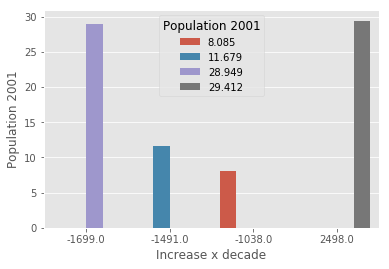

In [84]:
ax = sns.barplot(x="Increase x decade", y="Population 2001", hue="Population 2001", data=info_stack[1:5],estimator=np.median)

In [85]:
nb_select.sort_values('Population 2001',ascending=False)

,Neighborhood,Population 2001,Increase x decade,Borough,Location
3,BARRIO NUEVA CÓRDOBA,29.412,2498.0,ZONA CENTRAL,"Paseo del Buen Pastor, X5000"
0,BARRIO CENTRO,28.949,-1699.0,ZONA CENTRAL,"Plaza San Martin, X5000"
1,BARRIO CENTRO,28.949,-1699.0,ZONA CENTRAL,"Paseo Sobremonte, X5000"
2,BARRIO GÜEMES,11.679,-1491.0,ZONA CENTRAL,"Museo iberoamericano de artesanias de Fundart,..."
4,BARRIO GENERAL PAZ,8.085,-1038.0,ZONA PERICENTRAL ESTE,"Plaza Alberdi, X5004"


<a name="methodology"></a>
# Methodology    
* We will start by extracting the data from the wikipedia by the data scraping method, which will filter the most relevant information to represent, 5 selected key locations.

* We will understand the proportion of the population that lives in the neighborhoods according to information from a census conducted in 2001, and we will be able to compare their percentage of growth measured in decades. 

* We will obtain their coordinates to be able to geolocate them and represent the neighborhoods on the map, to create the 5 points of interest and based on each point, within a radius of 500 meters, filter the most frequent places to establish a framework of informative data, which will be analyzed and discussed for understanding.

* Finally we will segment it by means of clusters to devise different paths and conclusions to follow.
  creating groups (using k-means grouping) will try to optimize the distances between the 5 zones and be able to determine which categories are most important by grouping them according to  this method.

_For the development of the project we used the Fundamental Methodology for Data Science._


<a id="analysis"></a>
# Analysis 
Using information from wikipedia's filtered data frame, geographic coordinates are extracted and new information is added to the data frame for further exploration and analysis.

In [87]:
geo_data = nb_select
geolocator = Nominatim(user_agent="ny_explorer")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
geo_data['Address'] = geo_data['Location'].progress_apply(geocode)
#geo_data['Point'] = geo_data['Location'].progress_apply(lambda loc: tuple(loc.point) if loc else None)
geo_data['Latitude'] = geo_data['Address'].progress_apply(lambda x: x.latitude if x != None else None)
geo_data['Longitude'] = geo_data['Address'].progress_apply(lambda x: x.longitude if x != None else None)
geo_data

100%|██████████| 5/5 [00:00<00:00, 7455.22it/s]


,Neighborhood,Population 2001,Increase x decade,Borough,Location,Address,Latitude,Longitude
0,BARRIO CENTRO,28.949,-1699.0,ZONA CENTRAL,"Plaza San Martin, X5000","(Plaza San Martín, Centro, Córdoba, Municipio ...",-31.416735,-64.183580
1,BARRIO CENTRO,28.949,-1699.0,ZONA CENTRAL,"Paseo Sobremonte, X5000","(Paseo Sobremonte, Centro, Córdoba, Municipio ...",-31.415514,-64.192101
2,BARRIO GÜEMES,11.679,-1491.0,ZONA CENTRAL,"Museo iberoamericano de artesanias de Fundart,...",(Museo iberoamericano de artesanias de Fundart...,-31.423827,-64.192175
3,BARRIO NUEVA CÓRDOBA,29.412,2498.0,ZONA CENTRAL,"Paseo del Buen Pastor, X5000","(Paseo Del Buen Pastor, Buenos Aires, Nueva Có...",-31.424083,-64.186420
4,BARRIO GENERAL PAZ,8.085,-1038.0,ZONA PERICENTRAL ESTE,"Plaza Alberdi, X5004","(Plaza Alberdi, General Paz, Córdoba, Municipi...",-31.414336,-64.170391


### Creating a map of Córdoba City
The coordinates of the city of Cordoba are extracted to be represented on the map. 

In [88]:
address = 'CORDOBA,AR'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
cba_map = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(geo_data['Latitude'], geo_data['Longitude'], geo_data['Location']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        icon=folium.Icon(color="orange"),
        parse_html=False).add_to(cba_map) 
    
for lat, lng, label in zip(geo_data['Latitude'], geo_data['Longitude'], geo_data['Location']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=12,
        #popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cba_map)      
    
cba_map

#### Foursquare's API
* According to the points of interest, the information will be filtered in a radius of 500 mts , it will be loaded in a Json file and it will be transformed in a data frame to be able to work it.  
* The API information will be filtered and we will keep the most relevant information forming a new data frame to explore its categories.

In [89]:
cba_data = geo_data
data_latitude = cba_data.loc[0, 'Latitude'] # neighborhood latitude value
data_longitude = cba_data.loc[0, 'Longitude'] # neighborhood longitude value
data_name = cba_data.loc[0, 'Neighborhood'] # neighborhood name
# Config - API
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    data_latitude, 
    data_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [90]:
# Transform data
venues = results['response']['groups'][0]['items']    
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print("size: ",nearby_venues.shape)
nearby_venues.head()

size:  (61, 4)


,name,categories,lat,lng
0,Le Dureau,Coffee Shop,-31.418298,-64.184727
1,Sibaris,French Restaurant,-31.418725,-64.183696
2,Windsor Hotel & Tower,Hotel,-31.418804,-64.183724
3,Azur Real Hotel Boutique Córdoba,Hotel,-31.417984,-64.181131
4,Manzana Jesuítica,History Museum,-31.418361,-64.186496


Data frame with the categories.

In [91]:
# Join
CBA_venues = getNearbyVenues(names=cba_data['Neighborhood'],
                             latitudes=cba_data['Latitude'],
                             longitudes=cba_data['Longitude'])
print(CBA_venues.shape)
CBA_venues.head()

BARRIO CENTRO
BARRIO CENTRO
BARRIO GÜEMES
BARRIO NUEVA CÓRDOBA
BARRIO GENERAL PAZ
(299, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BARRIO CENTRO,-31.416735,-64.18358,Le Dureau,-31.418298,-64.184727,Coffee Shop
1,BARRIO CENTRO,-31.416735,-64.18358,Sibaris,-31.418725,-64.183696,French Restaurant
2,BARRIO CENTRO,-31.416735,-64.18358,Windsor Hotel & Tower,-31.418804,-64.183724,Hotel
3,BARRIO CENTRO,-31.416735,-64.18358,Azur Real Hotel Boutique Córdoba,-31.417984,-64.181131,Hotel
4,BARRIO CENTRO,-31.416735,-64.18358,Manzana Jesuítica,-31.418361,-64.186496,History Museum


Data frame with the categories filtered and added to the previous data frame with their respective coordinates

In [92]:
# Category Filtering 
fil_1 = CBA_venues['Neighborhood'] == 'BARRIO CENTRO'
fil_2 = CBA_venues['Neighborhood'] == 'BARRIO GÜEMES'
fil_3 = CBA_venues['Neighborhood'] == 'BARRIO NUEVA CÓRDOBA'
fil_4 = CBA_venues['Neighborhood'] == 'BARRIO GENERAL PAZ'
print("Total Categories")
print("BARRIO CENTRO - Plaza San Martin & Paseo Sobremonte: ",CBA_venues[fil_1]['Venue Category'].count())
print("BARRIO GÜEMES - Museo: ",CBA_venues[fil_2]['Venue Category'].count())
print("BARRIO NUEVA CÓRDOBA - Paseo del Buen Pastor: ",CBA_venues[fil_3]['Venue Category'].count())
print("BARRIO GENERAL PAZ - Plaza Alberdi: ",CBA_venues[fil_4]['Venue Category'].count())
CBA_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).transpose()

Total Categories
BARRIO CENTRO - Plaza San Martin & Paseo Sobremonte:  84
BARRIO GÜEMES - Museo:  77
BARRIO NUEVA CÓRDOBA - Paseo del Buen Pastor:  100
BARRIO GENERAL PAZ - Plaza Alberdi:  38


Venue Category,Argentinian Restaurant,Sandwich Place,Cocktail Bar,Hotel,Coffee Shop,Café,Bar,Nightclub,Gastropub,Gym,...,Grocery Store,Gym Pool,Hotel Bar,Irish Pub,Japanese Restaurant,Juice Bar,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Historic Site
Neighborhood,21,16,13,12,12,12,11,10,9,9,...,1,1,1,1,1,1,1,1,1,1
Neighborhood Latitude,21,16,13,12,12,12,11,10,9,9,...,1,1,1,1,1,1,1,1,1,1
Neighborhood Longitude,21,16,13,12,12,12,11,10,9,9,...,1,1,1,1,1,1,1,1,1,1
Venue,21,16,13,12,12,12,11,10,9,9,...,1,1,1,1,1,1,1,1,1,1
Venue Latitude,21,16,13,12,12,12,11,10,9,9,...,1,1,1,1,1,1,1,1,1,1
Venue Longitude,21,16,13,12,12,12,11,10,9,9,...,1,1,1,1,1,1,1,1,1,1


* We can see the most relevant categories ordered from highest to lowest frequency.
* We can emphasize that the gastronomy in the category of restaurants of Argentine food is the one that dominates.

### Quick view 
We can see a list of the most outstanding trade names from 3 different categories.

#### Argentinian Restaurant

In [93]:
cat1 = CBA_venues['Venue Category'] == 'Argentinian Restaurant'
CBA_venues[cat1]['Venue'].to_frame().transpose()

,24,27,36,42,65,124,129,131,139,155,...,236,240,248,265,268,273,274,281,284,295
Venue,Mandarina!,La Candela,Alfonsina,La Perla Restaurant,Estacion 27,Los Infernales de Güemes,Alfonsina,Alcorta - Carnes y Vinos,Casa de Fuego,Sissi - Tienda bar,...,Los Infernales de Güemes,Alfonsina,El Club de la Milanesa,San Honorato,Viejo Lobo,Lo de Villalpando,Casa Criolla,Junior B,El Club de la Milanesa,La Perla Restaurant


#### Hotel

In [94]:
cat2 = CBA_venues['Venue Category'] == 'Hotel'
CBA_venues[cat2]['Venue'].to_frame().transpose()

,2,3,20,56,57,71,102,103,150,164,238,247
Venue,Windsor Hotel & Tower,Azur Real Hotel Boutique Córdoba,Sacha Mistol,Merit Gran Hotel Victoria,Hotel Felipe II,Howard Johnson Hotel & Suites - La Cañada,Y111 Hotel,Hotel de la Cañada,Sol De Piedra,Y111 Hotel,Sol De Piedra,Amerian Executive Córdoba Hotel


#### Nightclub

In [95]:
cat3 = CBA_venues['Venue Category'] == 'Nightclub'
CBA_venues[cat3]['Venue'].to_frame().transpose()

,18,72,115,119,159,201,207,218,237,250
Venue,Studio Theatre,Pétalos de sol,Minns,Le Parc,María María,Paris,Minns,Le Parc,UK,El Sol


### Transforming data
* a) - Comparison of the 5 most frequent sites among the 5 chosen research areas.
* b) - Comparison of the 10 most frequent sites among the 5 research areas chosen and stored in a data frame.

In [96]:
# Transforming information into numerical values
CBA_onehot = pd.get_dummies(CBA_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
CBA_onehot['Neighborhood'] = CBA_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [CBA_onehot.columns[-1]] + list(CBA_onehot.columns[:-1])
CBA_onehot = CBA_onehot[fixed_columns]
CBA_grouped = CBA_onehot.groupby('Neighborhood').mean().reset_index()

#### a) - Top 5 frequencies venues

In [97]:
num_top_venues = 5

for hood in CBA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = CBA_grouped[CBA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BARRIO CENTRO----
            venue  freq
0     Coffee Shop  0.10
1           Hotel  0.07
2            Café  0.07
3        Pharmacy  0.06
4  Sandwich Place  0.06


----BARRIO GENERAL PAZ----
                    venue  freq
0  Argentinian Restaurant  0.18
1                     Bar  0.05
2      Mexican Restaurant  0.05
3                    Café  0.05
4        Sushi Restaurant  0.05


----BARRIO GÜEMES----
                    venue  freq
0                     Bar  0.09
1            Cocktail Bar  0.09
2  Argentinian Restaurant  0.06
3               Gastropub  0.05
4                   Hotel  0.04


----BARRIO NUEVA CÓRDOBA----
            venue  freq
0  Sandwich Place  0.07
1             Gym  0.05
2       Gastropub  0.05
3    Cocktail Bar  0.05
4       Nightclub  0.05




#### b) - Top 10 venues

In [98]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = CBA_grouped['Neighborhood']
for ind in np.arange(CBA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CBA_grouped.iloc[ind, :], num_top_venues)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(4, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BARRIO CENTRO,Coffee Shop,Café,Hotel,Pharmacy,Sandwich Place,Argentinian Restaurant,Fast Food Restaurant,Diner,Plaza,Ice Cream Shop
1,BARRIO GENERAL PAZ,Argentinian Restaurant,Mexican Restaurant,Ice Cream Shop,Café,Sushi Restaurant,Bar,Restaurant,Park,Cocktail Bar,Middle Eastern Restaurant
2,BARRIO GÜEMES,Bar,Cocktail Bar,Argentinian Restaurant,Gastropub,Bakery,Hotel,Sandwich Place,Nightclub,Brewery,Beer Garden
3,BARRIO NUEVA CÓRDOBA,Sandwich Place,Cocktail Bar,Nightclub,Gym,Gastropub,Argentinian Restaurant,Fast Food Restaurant,Café,Hotel,Bakery


<a id="ref4"></a>
# 4. Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 4 clusters.

In [99]:
cba_data = geo_data
cba_data.drop(['Population 2001','Increase x decade','Location','Address'], axis = 1, inplace = True)
# set number of clusters
kclusters = 4

CBA_grouped_clustering = CBA_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CBA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 3], dtype=int32)

In [100]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

CBA_merged = cba_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
CBA_merged = CBA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

CBA_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BARRIO CENTRO,ZONA CENTRAL,-31.416735,-64.183580,0,Coffee Shop,Café,Hotel,Pharmacy,Sandwich Place,Argentinian Restaurant,Fast Food Restaurant,Diner,Plaza,Ice Cream Shop
1,BARRIO CENTRO,ZONA CENTRAL,-31.415514,-64.192101,0,Coffee Shop,Café,Hotel,Pharmacy,Sandwich Place,Argentinian Restaurant,Fast Food Restaurant,Diner,Plaza,Ice Cream Shop
2,BARRIO GÜEMES,ZONA CENTRAL,-31.423827,-64.192175,1,Bar,Cocktail Bar,Argentinian Restaurant,Gastropub,Bakery,Hotel,Sandwich Place,Nightclub,Brewery,Beer Garden
3,BARRIO NUEVA CÓRDOBA,ZONA CENTRAL,-31.424083,-64.186420,3,Sandwich Place,Cocktail Bar,Nightclub,Gym,Gastropub,Argentinian Restaurant,Fast Food Restaurant,Café,Hotel,Bakery
4,BARRIO GENERAL PAZ,ZONA PERICENTRAL ESTE,-31.414336,-64.170391,2,Argentinian Restaurant,Mexican Restaurant,Ice Cream Shop,Café,Sushi Restaurant,Bar,Restaurant,Park,Cocktail Bar,Middle Eastern Restaurant


### We will represent it on the map and explore the grouped categories.

In [101]:
address = 'CORDOBA,AR'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CBA_merged['Latitude'], CBA_merged['Longitude'], CBA_merged['Neighborhood'], CBA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [102]:
CBA_merged.loc[CBA_merged['Cluster Labels'] == 0, CBA_merged.columns[[1] + list(range(5, CBA_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ZONA CENTRAL,Coffee Shop,Café,Hotel,Pharmacy,Sandwich Place,Argentinian Restaurant,Fast Food Restaurant,Diner,Plaza,Ice Cream Shop
1,ZONA CENTRAL,Coffee Shop,Café,Hotel,Pharmacy,Sandwich Place,Argentinian Restaurant,Fast Food Restaurant,Diner,Plaza,Ice Cream Shop


#### Cluster 2

In [103]:
CBA_merged.loc[CBA_merged['Cluster Labels'] == 1, CBA_merged.columns[[1] + list(range(5, CBA_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,ZONA CENTRAL,Bar,Cocktail Bar,Argentinian Restaurant,Gastropub,Bakery,Hotel,Sandwich Place,Nightclub,Brewery,Beer Garden


#### Cluster 3

In [104]:
CBA_merged.loc[CBA_merged['Cluster Labels'] == 2, CBA_merged.columns[[1] + list(range(5, CBA_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,ZONA PERICENTRAL ESTE,Argentinian Restaurant,Mexican Restaurant,Ice Cream Shop,Café,Sushi Restaurant,Bar,Restaurant,Park,Cocktail Bar,Middle Eastern Restaurant


#### Cluster 4

In [105]:
CBA_merged.loc[CBA_merged['Cluster Labels'] == 3, CBA_merged.columns[[1] + list(range(5, CBA_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,ZONA CENTRAL,Sandwich Place,Cocktail Bar,Nightclub,Gym,Gastropub,Argentinian Restaurant,Fast Food Restaurant,Café,Hotel,Bakery


## Results and Discussion <a name="results"></a>

**BARRIO CENTRO:**  the analysis shows a greater demand for cafeterias and hotels, leaving the houses of Argentine food or some snack or fast food in a fourth place; in the central area investigated, two green spaces with a lot of social movement stand out, which are the San Martín Square located next to the town hall and the cathedral church (historical symbol), the other place is the Sobre-monte walk, a place very close to public work entities such as provincial courts of justice, surrounded by a lot of cultural movement. 

_It is quite clear that for these two locations the cafeterias or lodging places predominate since the movement is very varied people who live here eat in other places and those who do not live here are just passing through._

**BARRIO GÜEMES:** This is a well-known sector of the city of Córdoba, where it is very popular with visitors or natives of the province. The area studied is an area of immigrants from many different cultures, and there are many different activities such as shows, crafts, food, beer ... As for the most popular categories, according to the results, cafeterias with drinks and fast and regional food predominate. 

_In the last years the commerce was growing in many categories and many areas close their streets and become pedestrian during the weekends so that the great flow of people can transit, walk and consume. The place has lately become fashionable for breweries and night clubs._

**BARRIO NUEVA CÓRDOBA:** One of the most dynamic sectors of Cordoba's economic, cultural and recreational life. Very popular with students and with a high increase in population growth. The categories that epredominate are the houses of sandwiches or fast food, gym night clubs and houses of drinks.

_The nightlife is very busy in this area as it is overcrowded with many students. It is an area close to the university city. Young people prefer the night, fast food and exercise_

**BARRIO GENERAL PAZ:** Is a neighborhood that was developed in the mid-nineteenth century. It has a lot of social movement and it is one of the most frequented for the gastronomic movement, the international Argentine food covers the biggest frequency of interests, there is a lot of variety of ice cream shops and bars.

_It is a neighborhood near the government house, with a lot of history and gastronomic movement._ 

<a name="conclusion"></a>
# Conclusion 

The purpose of this project was to identify the most frequent categories by people in 4 areas with 5 specific places with a lot of socio-cultural movement, in order to provide information about the category movement to the person who is starting it or by way of information as a tool to improve decision making.
The final decision on the best categories or places may vary according to the investigated area and the desired heading, the precision can be improved by changing the code by replacing the values of interest based on the specific characteristics of the neighborhoods and the locations in each recommended area.

<a name="resources"></a>
# Resources
<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
    <li><a href="https://es.wikipedia.org/wiki/C%C3%B3rdoba_(Argentina)">Córdoba</a></li>
    <li><a href="https://es.wikipedia.org/wiki/Barrio_G%C3%BCemes_(C%C3%B3rdoba)">Barrio Guemes</a></li>
    <li><a href="http://wikimapia.org/89305/es/Paseo-Sobremonte">Paseo Sobremonte</a></li>
    <li><a href="https://es.wikipedia.org/wiki/Barrio_General_Paz_(C%C3%B3rdoba)">Barrio Gral Paz</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">K-means</a></li>
    <li><a href="https://www.coursera.org/learn/applied-data-science-capstone">Applied Data Science Capstone</a></li>
    <li><a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">Beautiful Soup Documentation</a></li>
    <li><a href="https://requests.readthedocs.io/en/master/">Request Documentation</a></li>
    <li><a href="https://pandas.pydata.org/docs/">Pandas Documentation</a></li>
    <li><a href="https://numpy.org/doc/">NumPy Documentation</a></li>
    <li><a href="https://github.com/Azhura/Coursera_Capstone">Labs</a></li>
</ul>
</div>

<div class="alert alert-block alert-info" style="margin-top: 20px">Link´s to the notebooks</div><br>
<a href="https://github.com/Azhura/Coursera_Capstone/blob/master/Final.ipynb">Github - Notebook</a><br>

<a href="https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/510be702-0edd-4d42-8a6d-7a742eaaf59d/view?access_token=5f6d191161a8c8ac5bb3edd176715b462ea45bf6f3825f382ee3a75020523249">Display with map</a>

This notebook was created by [Carlos Alberto Gómez Prado](https://www.linkedin.com/in/carlospradobigdata/), as an assignment for the IBM coursera course.   

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](https://www.coursera.org/professional-certificates/ibm-data-science).   
Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).

---